In [1]:
from RunManager import RunManager
import numpy as np
import matplotlib.pyplot as plt
import uproot
import awkward as ak

In [2]:
manager = RunManager("../scripts/config.json")
manager.display_all_runs()

,id,particle,energy,fastSimulation,maxScatters,maxEnergy,sourceVolume,outputDir,outputFile,settingsFile,numEvents,status
0,run_01,geantino,1.MeV,true,1,0.2 MeV,InnerCryostat,/data/xenon/acolijn/G4FastSim/20240723_164712,fast.root,settings.json,1000000,active
1,run_02,gamma,1.MeV,false,-999,-1 MeV,InnerCryostat,/data/xenon/acolijn/G4FastSim/20240723_164859,std.root,settings.json,1000000,active


In [3]:
file = uproot.open(manager.get_output_root_file("run_01"))

gp = file["diff_xsec"]
ev = file["ev"].arrays()

In [4]:
cost=gp["cost"].array()
ff=gp["ff"].array()
mat=gp["mat"].array()
kn=gp["kn"].array()
z=gp["Z"].array()

# print unique values from mat array
print(np.unique(mat))


['Ar', 'C', 'Cr', 'F', 'Fe', 'H', 'N', 'Ni', 'O', 'Xe']


In [5]:
import numpy as np
import matplotlib.pyplot as plt

def plot_klein_nishina(material, cosThetaMin, normalize=True):
    cut = (mat == material)
    y_values_z = kn[cut] * z[cut]
    y_values_ff = kn[cut] * ff[cut]
    cost_cut = cost[cut]

    if normalize:
        # Calculate normalization over the histogram range
        hist_min = cosThetaMin
        hist_max = 1.0
        mask = (cost_cut >= hist_min) & (cost_cut <= hist_max)
        
        area_z = np.trapz(y_values_z[mask], cost_cut[mask])
        area_ff = np.trapz(y_values_ff[mask], cost_cut[mask])
        y_values_z = y_values_z / area_z
        y_values_ff = y_values_ff / area_ff

    plt.plot(cost_cut, y_values_z, linestyle='--', color="black", label='Klein-Nishina')
    plt.plot(cost_cut, y_values_ff, linestyle='-', color="blue", label='Klein-Nishina + Form Factor')
    plt.xlabel("cos($\\theta$)")
    plt.ylabel("Normalized d$\sigma$/d$\Omega$ (a.u.)")
    plt.legend()

#### Function to Plot Histogram

def plot_hist(threshold=0.01, normalize=True):
    h = file['cost']
    bin_contents = h.values()
    bin_edges = h.axis().edges()
    bin_widths = np.diff(bin_edges)

    if normalize:
        area_hist = np.sum(bin_contents * bin_widths)
        bin_contents = bin_contents / area_hist

    
    # Find the first bin over the threshold
    cosTheta_min = None
    for content, edge in zip(bin_contents, bin_edges[:-1]):
        if content > threshold:
            cosTheta_min = edge
            break

    plt.hist(bin_edges[:-1], bins=bin_edges, weights=bin_contents, histtype='step', edgecolor='red', label='MC generated')
    plt.xlabel('$\\cos(\\theta)$')
    plt.ylabel('Normalized $dN / d\\cos(\\theta)$')
    plt.title('Compton scatter angles for Xe')
    plt.grid(True)
    plt.legend()
    
    return cosTheta_min


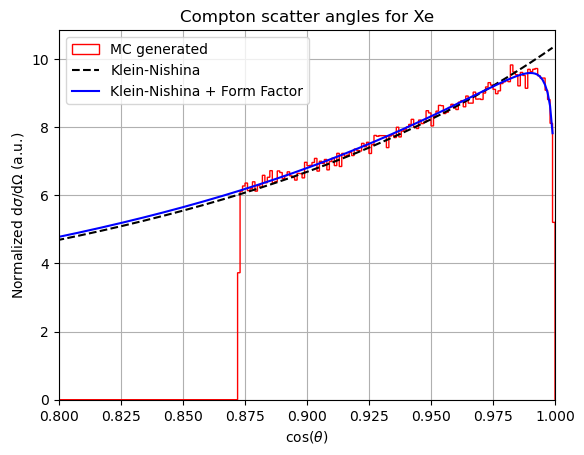

In [10]:
#fig, ax = plt.subplots()

# Plot the histogram and retrieve the bin edges
cosThetaMin = plot_hist()

# Plot the Klein-Nishina distribution
plot_klein_nishina('Xe', cosThetaMin)

plt.xlim(0.8, 1.0)
plt.show()

In [1]:
# import hdf5 library
import h5py